# Ancillary Datasets

In order to use external/ancillary datasets as feature layers in the crop ML model, we need to resample the datasets to match Sentinel2.  The code here tests the workflow for resampling.  

Also testing creating a slope layer.

`xr_reproject` is a new function and needs to be installed manually as per below: 

     !pip install -U --no-deps --extra-index-url="https://packages.dea.ga.gov.au" odc-algo

### Try reprojecting CHIRPS

Issue with `.geobox` expecting lat/lon as coords rather than xy, will be fixed in `ODC1.8.1`. Code currently works on the `unstable` sandbox

Created an `annual cumulative rainfall climatology` for the world (`'data/CHIRPS/CHP_clim_sum.nc'`):

    z = []
    for i in os.listdir('data/CHIRPS/'):
        x = assign_crs(xr.open_rasterio('data/CHIRPS/'+ i))
        z.append(x)

    a = xr.concat(z, dim='band').where(a>-10).sum('band').where(a>0)

In [1]:
from odc.algo import xr_reproject
from datacube.utils.geometry import assign_crs
import xarray as xr
import datacube
import os
import sys
import numpy as np
# sys.path.append('../Scripts')
# from deafrica_datahandling import load_ard
# # from deafrica_dask import create_local_dask_cluster

In [2]:
dc = datacube.Datacube(app='reprojection')

# Define area of interest
lat = 24.842#22.817
lon = 13.004#28.518
lon_buffer = 1.0 #0.0175
lat_buffer = 1.0 #0.004

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-lat_buffer, lat+lat_buffer)
lon_range = (lon-lon_buffer, lon+lon_buffer)

# Set the range of dates for the analysis
years_range = ('2018-01-01', '2018-01-05')

In [3]:
# Create a reusable query
query = {
    'y': lat_range,
    'x': lon_range,
    'time': years_range,
    'measurements': ['red'],
    'resolution': (-20,20),
    'output_crs': 'epsg:6933',
    'dask_chunks': {'x':1000, 'y':1000}
}

# Load available data from S2
ds = dc.load(product='s2_l2a',
              **query,
              )

print(ds)

<xarray.Dataset>
Dimensions:      (time: 3, x: 9649, y: 11605)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-02T09:33:56 ... 2018-01-05T09:44:07
  * y            (y) float64 3.189e+06 3.189e+06 ... 2.957e+06 2.957e+06
  * x            (x) float64 1.158e+06 1.158e+06 ... 1.351e+06 1.351e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


In [4]:
chirps=assign_crs(xr.open_rasterio('data/CHIRPS/CHPclim_sum.nc'),  crs='epsg:4326')
chirps

<xarray.DataArray (band: 1, y: 3600, x: 7200)>
[25920000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 89.97 89.92 89.87 89.82 ... -89.88 -89.93 -89.98
  * x            (x) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
    spatial_ref  int32 4326
Attributes:
    transform:     (0.05000000074505806, 0.0, -180.0, 0.0, -0.050000000745058...
    res:           (0.05000000074505806, 0.05000000074505806)
    is_tiled:      0
    nodatavals:    (nan,)
    scales:        (1.0,)
    offsets:       (0.0,)
    grid_mapping:  spatial_ref

In [5]:
chirps_20m = xr_reproject(chirps,
                         ds.geobox,
                         "mode",
                            )

chirps_20m = assign_crs(chirps_20m, crs=ds.geobox.crs)

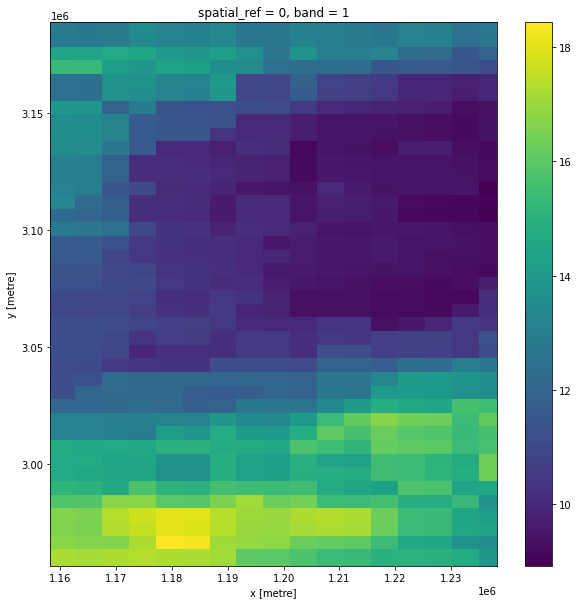

In [6]:
chirps_20m.isel(x=slice(0,4000)).plot(figsize=(10,10))

## Calculate Slope on SRTM

    !pip install richdem

In [ ]:
import os
import datacube
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import richdem as rd
import pyproj
import xarray as xr


In [ ]:
lat, lon = -3.064, 37.359
buffer = 0.1

query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    'output_crs': 'EPSG:6933',
    'resolution': (-30, 30)
}

dc = datacube.Datacube(app='slope')

#load data
da = dc.load(product ='srtm', **query)
da = da.elevation

In [ ]:
def xr_terrain(da, attribute=None):
    """
    Using the richdem package, calculates terrain attributes
    on a DEM stored in memory as an xarray.DataArray 
    
    Params
    -------
    da : xr.DataArray
    attribute : str
        One of the terrain attributes that richdem.TerrainAttribute()
        has implemented. e.g. 'slope_riserun', 'slope_percentage', 'aspect'.
        See all option here:  
        https://richdem.readthedocs.io/en/latest/python_api.html#richdem.TerrainAttribute
        
    """
    #remove time if its there
    da = da.squeeze()
    #convert to richdem array
    rda = rd.rdarray(da.data, no_data=da.attrs['nodata'])
    #add projection and geotransform
    rda.projection=pyproj.crs.CRS(da.attrs['crs']).to_wkt()
    rda.geotransform = da.geobox.affine.to_gdal()
    #calulate attribute
    attrs = rd.TerrainAttribute(rda, attrib=attribute)

    #return as xarray DataArray
    return xr.DataArray(attrs,
                        attrs=da.attrs,
                        coords={'x':da.x, 'y':da.y},
                        dims=['y', 'x'])

In [ ]:
%%time
slope = xr_terrain(da, 'slope_riserun')

In [ ]:
slope.plot(cmap='magma', figsize=(8,8), robust=True);